In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
PROJECT_PATH = '../'
TRAIN_PATH = '/scratch/ceph/swei20/data/pfsspec/train/ae/dataset/bosz/nowave/norm_mr_100k'
TEST_PATH = '/scratch/ceph/swei20/data/pfsspec/train/ae/dataset/bosz/nowave/norm_mr_10k'

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
import os
import sys
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [6]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [7]:
# Allow load project as module
sys.path.insert(0, PROJECT_PATH)

In [8]:
os.environ['PFSSPEC_DATA'] = r'/scratch/ceph/dobos/data/pfsspec'
os.environ['PYSYN_CDBS'] = os.path.join(os.environ['PFSSPEC_DATA'], 'cdbs')

In [9]:
# from pfsspec.data.dataset import Dataset
# from pfsspec.obsmod.spectrum import Spectrum

In [10]:
from viska.plot_svd import *

In [11]:
import tensorflow as tf
# tf.enable_v2_behavior()
gpus = tf.config.list_physical_devices('GPU') 
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [12]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Load dataset and plot some examples

In [18]:
with h5py.File(TRAIN_PATH, 'r') as f:
    x_train = f['X'][()]

In [29]:
assert not np.any(np.isnan(x_train))
x_train.shape

(100000, 4096)

In [30]:
with h5py.File(TEST_PATH, 'r') as f:
    x_test = f['X'][()]

In [31]:
assert not np.any(np.isnan(x_test))
x_test.shape

(10000, 4096)

### VAE

In [26]:
from viska.VAE import model

In [27]:
latent_dim = 8
m = model(latent_dim, lr=0.001)

In [28]:
m.vae.fit(x_train, epochs=5, batch_size=10)

Epoch 1/5
 2162/10000 [=====>........................] - ETA: 17s - loss: nan - reconstruction_loss: nan - kl_loss: nan

KeyboardInterrupt: 

In [ ]:
loss: 1.8789 - reconstruction_loss: 1.0213 - kl_loss: 0.8494

In [277]:
mVAE = m.vae

In [230]:
encoded_spec =  mVAE.encoder.predict(x_test[0].reshape(-1,4096))[0]

In [231]:
decoded_spec = mVAE.decoder.predict(encoded_spec)

In [232]:
decoded_spec

array([[ 0.03062304,  0.02497991,  0.03340212, ...,  0.01675866,
         0.01130948, -0.00768414]], dtype=float32)

In [233]:
decoded_spec.shape

(1, 4096)

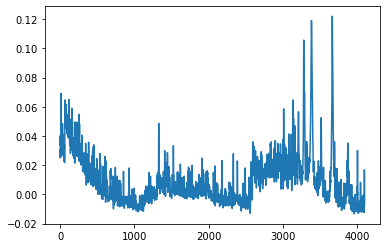

In [234]:
plt.plot(decoded_spec[0])

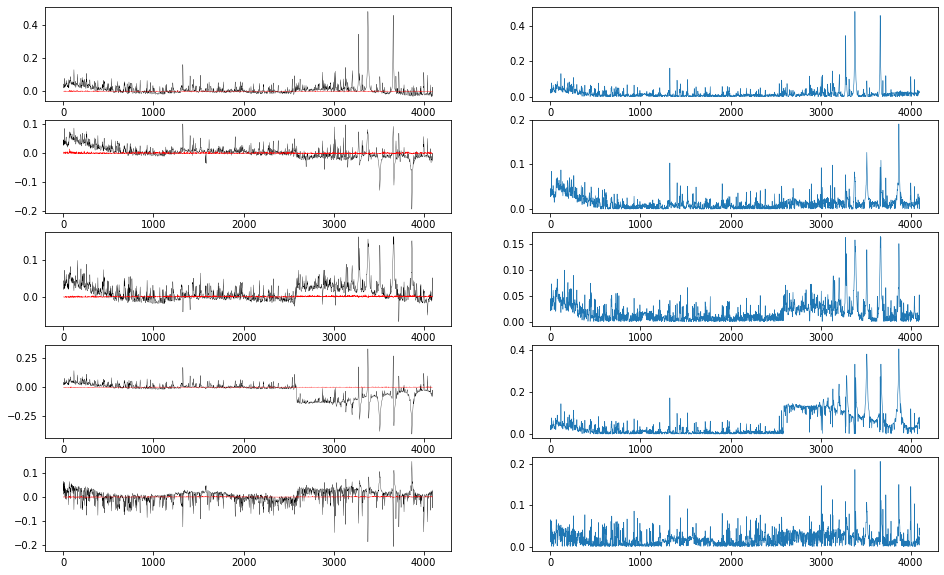

In [274]:
mVAE = m.vae
N = 5

f, axs = plt.subplots(N, 2, figsize=(16, 2 * N), squeeze=False)

# axs[0, 0].plot(ds.wave, avg, lw=0.3, c='r')
# axs[0, 1].plot(ds.wave, avg, lw=0.3, c='r')
# axs[0, 1].set_xlim(8000, 9000)

for i in range(N):
    test = x_test[i]
    axs[i , 0].plot(test, lw=0.3, c='k')
    encoded_spec =  mVAE.encoder.predict(test.reshape(-1, 4096))[-1]
    decoded_spec = mVAE.decoder.predict(encoded_spec)
    axs[i , 0].plot(decoded_spec[0], lw=0.3, c='r')
    axs[i , 1].plot(abs(test - decoded_spec[0]), lw = 0.6)
    
    

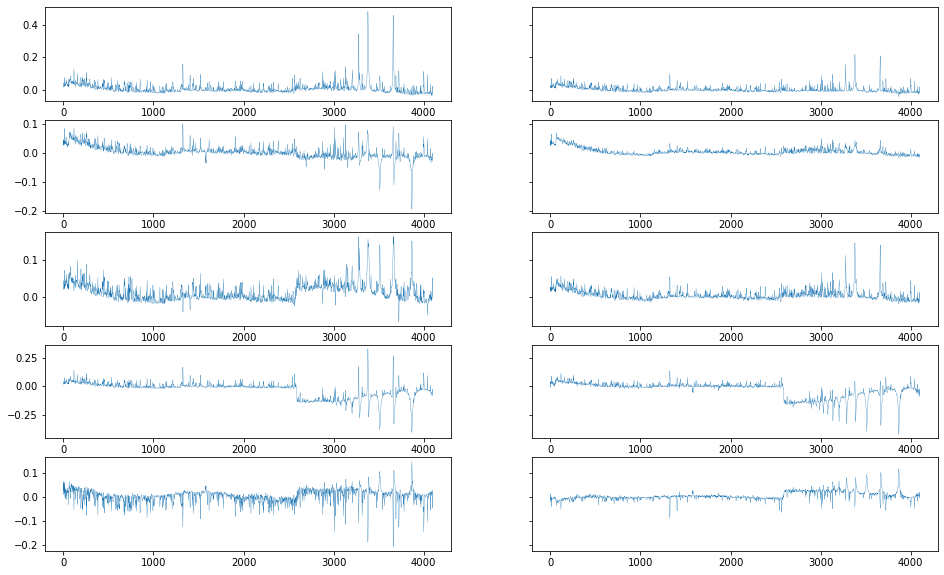

In [245]:
mVAE = m.vae
N = 5

f, axs = plt.subplots(N, 2, figsize=(16, 2 * N), squeeze=False, sharey="row")

# axs[0, 0].plot(ds.wave, avg, lw=0.3, c='r')
# axs[0, 1].plot(ds.wave, avg, lw=0.3, c='r')
# axs[0, 1].set_xlim(8000, 9000)

for i in range(N):
    test = x_test[i]
    axs[i , 0].plot(test, lw=0.3)
    encoded_spec =  mVAE.encoder.predict(test.reshape(-1, 4096))[-1]
    decoded_spec = mVAE.decoder.predict(encoded_spec)
    axs[i , 1].plot(decoded_spec[0], lw=0.3)
    

In [23]:
# autoencoder.fit(x_test, x_test, epochs=3, batch_size=32, validation_split=0.1)

In [13]:
n = 4096
encoder_input = keras.Input(shape = n, name = 'img')
x = keras.layers.Flatten()(encoder_input) #dense layer\
x = keras.layers.Dense(n//2, activation="relu")(x)
x = keras.layers.Dense(n//8, activation="relu")(x)
# x = keras.layers.Dense(n//8, activation="relu")(x)
encoder_output = x
encoder = keras.Model(encoder_input, encoder_output, name="encoder")

decoder_input = keras.layers.Dense(n//8, activation="relu")(encoder_output)
x = keras.layers.Dense(n//8, activation="relu")(decoder_input)
x = keras.layers.Dense(n//2, activation="relu")(x)
x = keras.layers.Dense(n, activation="relu")(x)
decoder_output = x

# decoder_output = keras.layers.Reshape((28,28,1))(decoder_input)
opt = keras.optimizers.Adam(learning_rate = 0.001, decay = 1e-6)

autoencoder = keras.Model(encoder_input, decoder_output, name="autoencoder")
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 4096)]            0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              8390656   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_4 (Dense)              (None, 2048)              

In [15]:
autoencoder.compile(opt, loss='mse')
autoencoder.fit(x_train, x_train, epochs=3, batch_size=32, validation_split=0.1)

Train on 9000 samples, validate on 1000 samples
Epoch 1/3
9000/9000 [==============================] - 2s 193us/sample - loss: 0.0033 - val_loss: 0.0036
Epoch 2/3
9000/9000 [==============================] - 1s 110us/sample - loss: 0.0032 - val_loss: 0.0036
Epoch 3/3
9000/9000 [==============================] - 1s 106us/sample - loss: 0.0032 - val_loss: 0.0036


In [30]:
autoencoder.compile(opt, loss='mse')
autoencoder.fit(x_train, x_train, epochs=10, batch_size=32, validation_split=0.1)

Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 159us/sample - loss: 0.0032 - val_loss: 0.0036
Epoch 2/10
9000/9000 [==============================] - 1s 123us/sample - loss: 0.0032 - val_loss: 0.0035
Epoch 3/10
9000/9000 [==============================] - 1s 130us/sample - loss: 0.0032 - val_loss: 0.0035
Epoch 4/10
9000/9000 [==============================] - 1s 123us/sample - loss: 0.0031 - val_loss: 0.0035
Epoch 5/10
9000/9000 [==============================] - 1s 118us/sample - loss: 0.0031 - val_loss: 0.0035
Epoch 6/10
9000/9000 [==============================] - 1s 135us/sample - loss: 0.0031 - val_loss: 0.0035
Epoch 7/10
9000/9000 [==============================] - 1s 122us/sample - loss: 0.0031 - val_loss: 0.0035
Epoch 8/10
9000/9000 [==============================] - 1s 125us/sample - loss: 0.0031 - val_loss: 0.0035
Epoch 9/10
9000/9000 [==============================] - 1s 126us/sample - loss: 0.0031 - val_loss: 0.003

### TESTING

In [16]:
with h5py.File(TEST_PATH, 'r') as f:
    x_test = f['X'][()]

In [17]:
x_test.shape

(10000, 4096)

### Latent Space

In [43]:
example = encoder.predict([x_test[:1, :]])[0]
example.shape

(512,)

In [50]:
idx = 4
ae_out = autoencoder.predict(x_test[idx])[0]

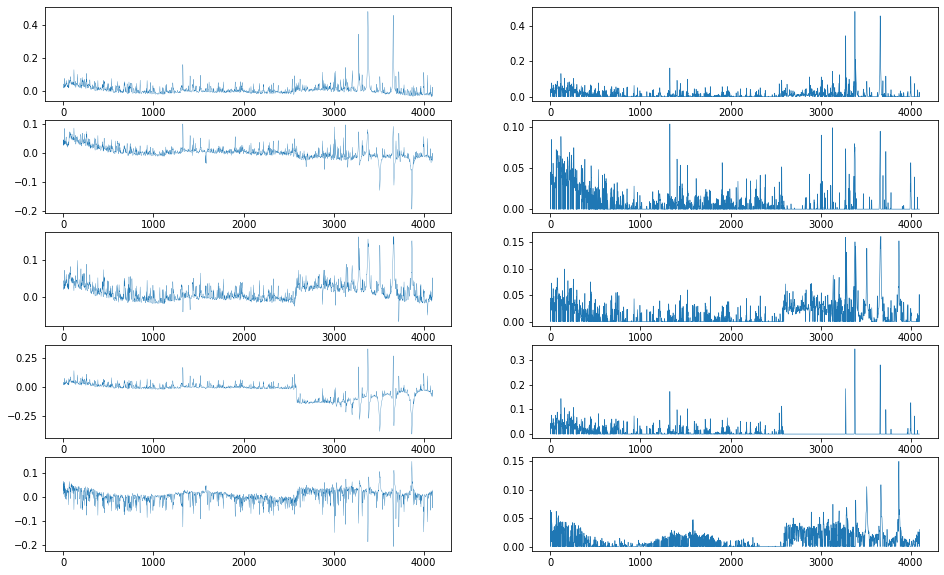

In [25]:
N = 5

f, axs = plt.subplots(N, 2, figsize=(16, 2 * N), squeeze=False)

# axs[0, 0].plot(ds.wave, avg, lw=0.3, c='r')
# axs[0, 1].plot(ds.wave, avg, lw=0.3, c='r')
# axs[0, 1].set_xlim(8000, 9000)

for i in range(N):
    test = x_test[i]
    axs[i , 0].plot(test, lw=0.3)
    ae_out =  autoencoder.predict(test.reshape(-1, 4096))[0]
    axs[i , 1].plot(ae_out, lw=0.6)

# Run PCA over flux data

In [81]:
ds.shape

(10000, 4096)

In [103]:
flux = ds.get_flux(np.s_[:, :])
flux.shape

(10000, 4096)

In [83]:
mm = np.median(flux, axis=1)
mm.shape

(10000,)

In [85]:
flux /= mm[..., np.newaxis]

In [87]:
X = np.log(flux)
avg = np.mean(X, axis=0)
X = X - avg
X.shape, avg.shape

((10000, 4096), (4096,))

In [102]:
SVD_PATH = '/scratch/ceph/swei20/data/pfsspec/train/ae/dataset/bosz/nowave/norm_mr_10k'

In [90]:
C = np.dot(X.transpose(), X)
C.shape

(4096, 4096)

In [91]:
U, S, V = np.linalg.svd(C)
U.shape, S.shape, V.shape

((4096, 4096), (4096,), (4096, 4096))

In [105]:
import h5py

In [106]:
with h5py.File(SVD_PATH, 'w') as f:
    f.create_dataset('flux', data=flux)
    f.create_dataset('X', data=X)
    f.create_dataset('U', data=U)
    f.create_dataset('S', data=S)
    f.create_dataset('V', data=V)

## Decline of eigenvalues

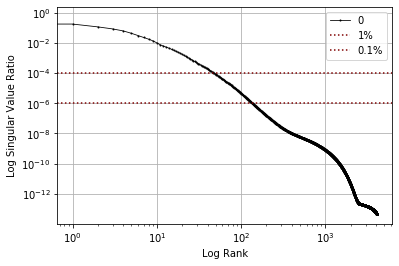

In [92]:
plot_svd_s([S])

## Eigenvectors

Eigenvalues drop to unity by $i = 30$, yet high order eigenspectra still seem to contain information relevan to line strengths.

In [93]:
ds.wave

array([7100.21362305, 7100.64086914, 7101.06811523, ..., 8848.93188477,
       8849.35913086, 8849.78637695])

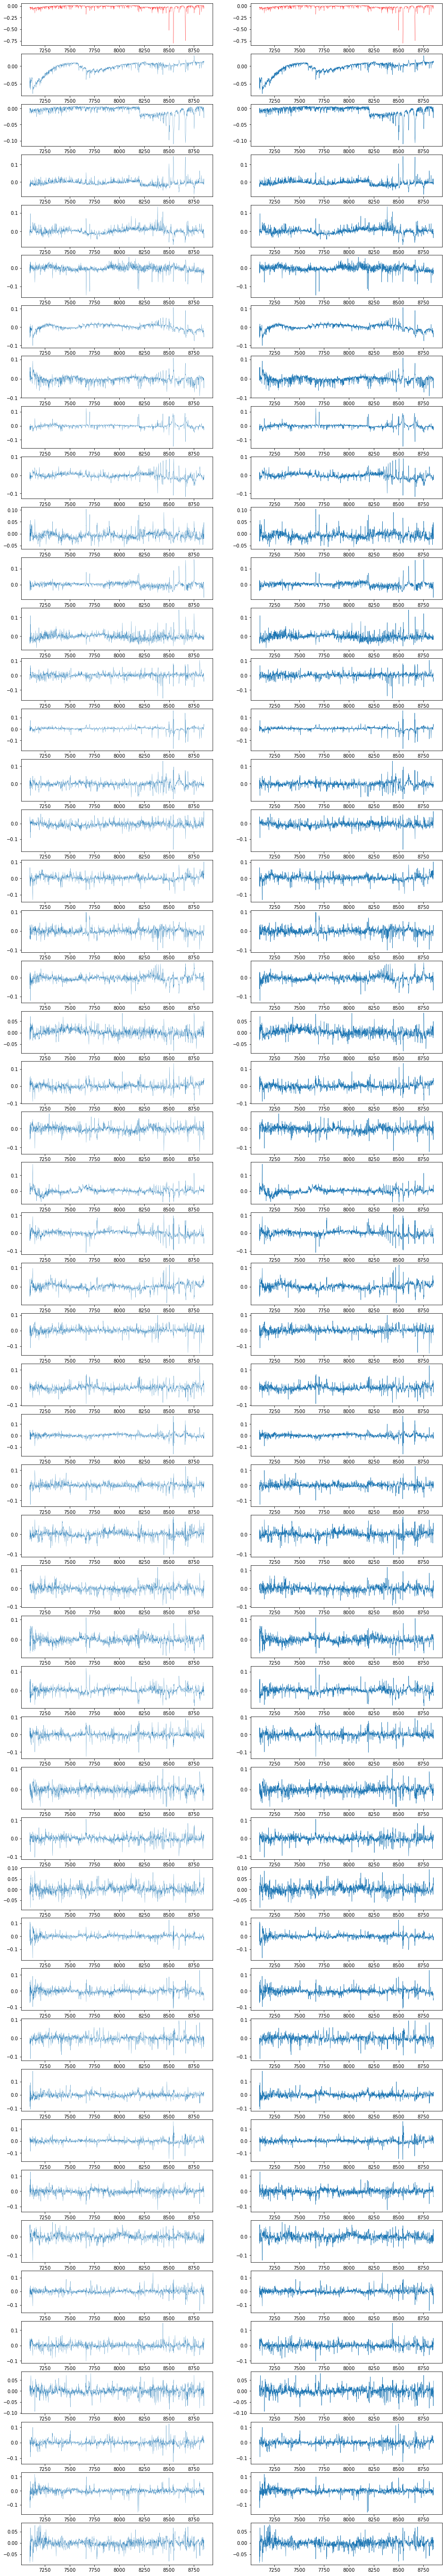

In [94]:
N = 50

f, axs = plt.subplots(N + 1, 2, figsize=(16, 2 * N), squeeze=False)

axs[0, 0].plot(ds.wave, avg, lw=0.3, c='r')
axs[0, 1].plot(ds.wave, avg, lw=0.3, c='r')
# axs[0, 1].set_xlim(8000, 9000)

for i in range(N):
    axs[i + 1, 0].plot(ds.wave, U[:, i], lw=0.3)
    axs[i + 1, 1].plot(ds.wave, U[:, i], lw=0.6)
    
#     axs[i + 1, 1].set_xlim(8000, 9000)

# Calculate principal components and expand on truncated basis

In [95]:
M = 50

PC = np.dot(X, U[:, 0:M])
PC.shape

(10000, 50)

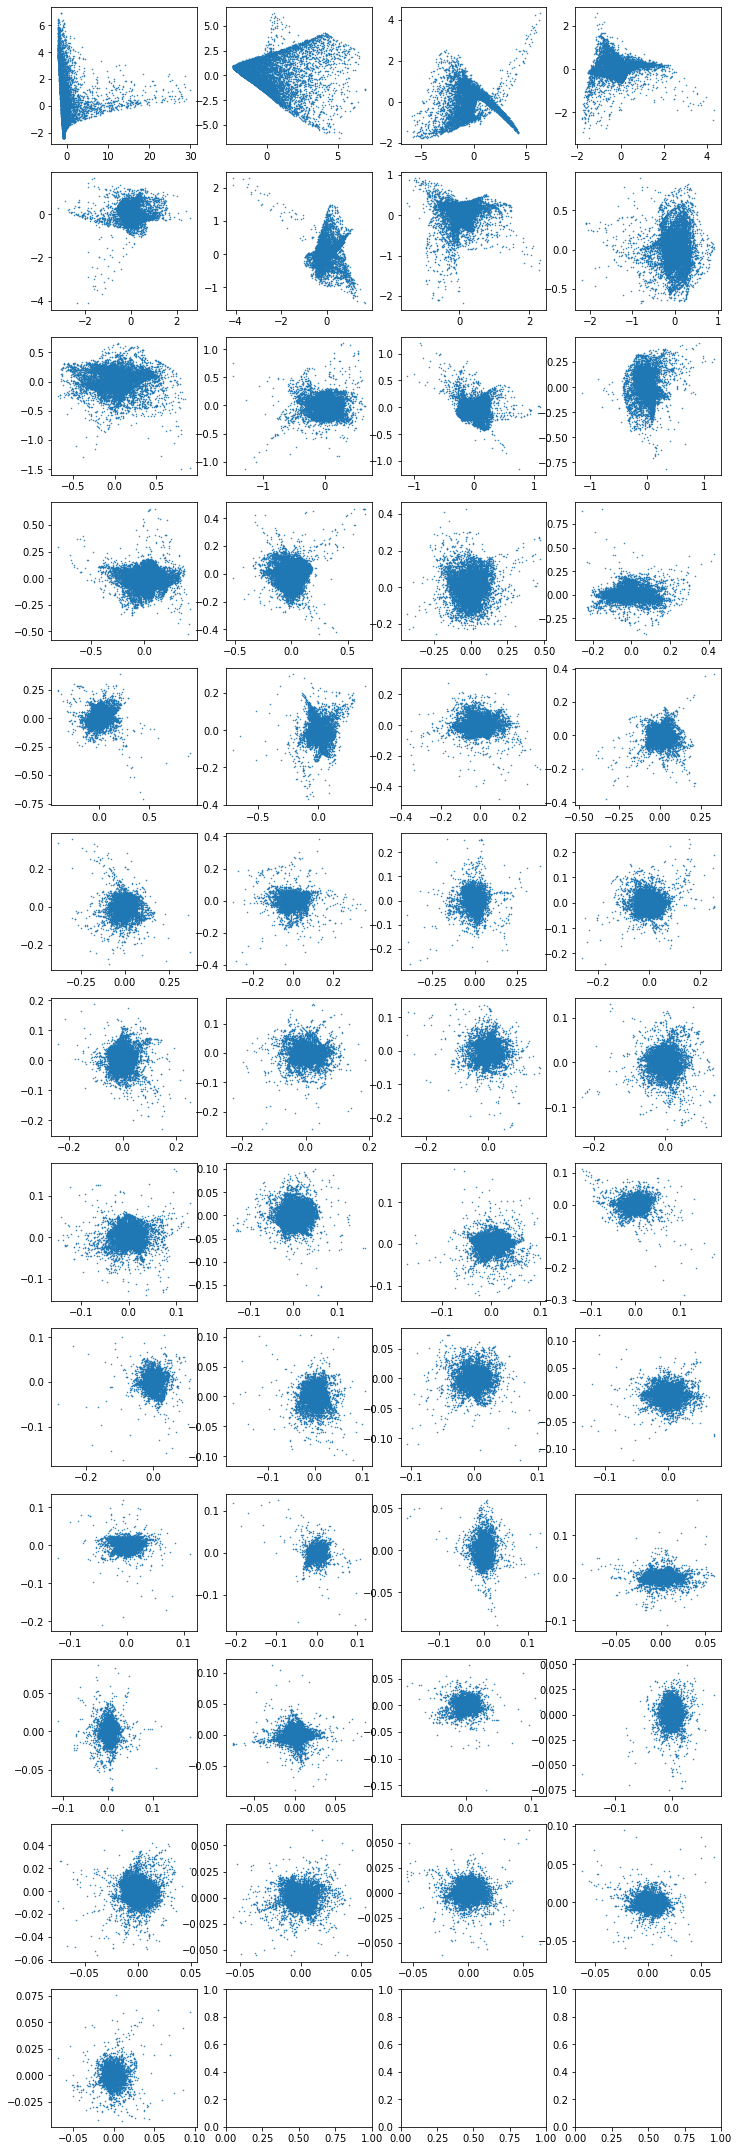

In [96]:
f, axs = plt.subplots(int(np.ceil(M / 4)), 4, figsize=(12, 3 * np.ceil(M / 4)))
axs = axs.flatten()

for i in range(M - 1):
    axs[i].plot(PC[:, i], PC[:, i + 1], '.', ms=1)

# Reconstruct from truncated basis

In [100]:
rflux = np.exp(avg + np.dot(PC, U[:, 0:M].transpose()))
rflux.shape

(10000, 4096)

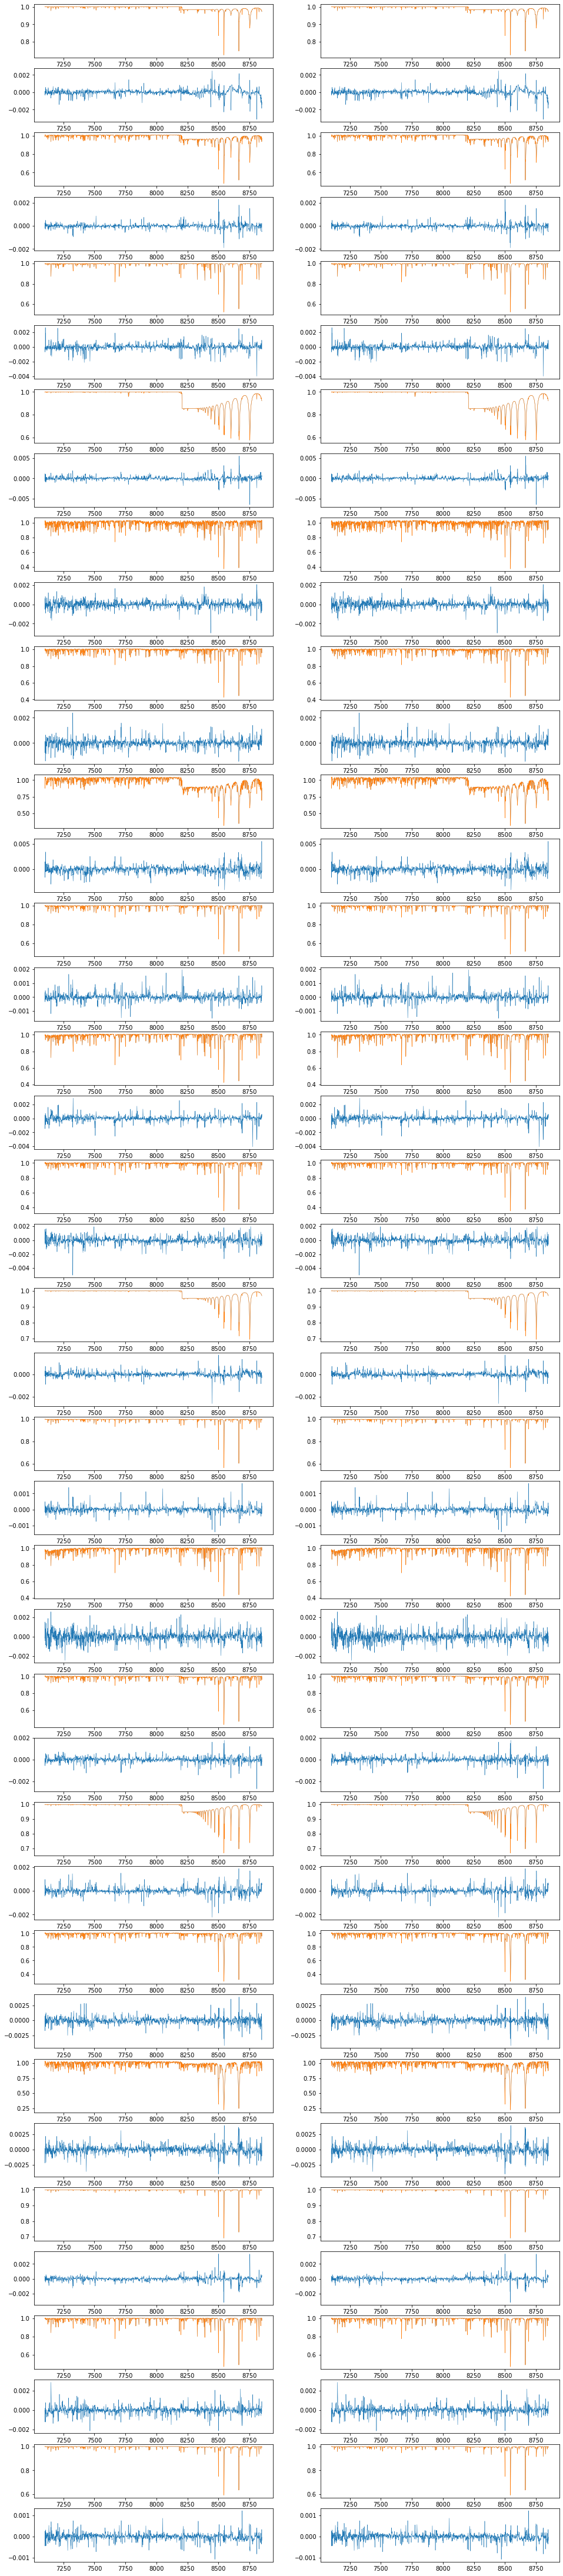

In [101]:
N = 20
f, axs = plt.subplots(2 * N, 2, figsize=(16, 4 * N), squeeze=False)

for i in range(N):
    axs[2 * i, 0].plot(wave, flux[i, :], lw=0.3)
    axs[2 * i, 0].plot(wave, rflux[i, :], lw=0.6)
    
    axs[2 * i, 1].plot(wave, flux[i, :], lw=0.3)
    axs[2 * i, 1].plot(wave, rflux[i, :], lw=0.6)
#     axs[2 * i, 1].set_xlim(8000, 9000)
    
    axs[2 * i + 1, 0].plot(wave, (flux[i, :] - rflux[i, :]) / flux[i, :], lw=0.5)
    
    axs[2 * i + 1, 1].plot(wave, (flux[i, :] - rflux[i, :]) / flux[i, :], lw=0.5)
#     axs[2 * i + 1, 1].set_xlim(8000, 9000)

In [41]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [42]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [43]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   320         input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten_4 (Flatten)             (None, 3136)         0           conv2d_1[0][0]                   
____________________________________________________________________________________________

In [44]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_17 (Dense)             (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

In [45]:

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [49]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(), loss='mse')
vae.fit(mnist_digits, epochs=30, batch_size=128)

AttributeError: 'NoneType' object has no attribute 'dtype'

In [47]:
tf.version

<module 'tensorflow_core._api.v2.version' from '/datascope/slurm/miniconda3/envs/astro-dnn/lib/python3.7/site-packages/tensorflow_core/_api/v2/version/__init__.py'>

In [48]:
tf.__version__

'2.1.0'